importing libraries


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2

In [25]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 3440.065  # Earth's radius in nautical miles
    
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    
    return R * c

In [26]:
file_path ="data.xlsx"

In [27]:
df = pd.read_excel(file_path)
df

,id,event,dateStamp,timeStamp,voyage_From,lat,lon,imo_num,voyage_Id,allocatedVoyageId
0,1,SOSP,43831,0.708333,Port A,34.0522,-118.2437,9434761,6,NaN
1,2,EOSP,43831,0.791667,Port A,34.0522,-118.2437,9434761,6,NaN
2,3,SOSP,43832,0.333333,Port B,36.7783,-119.4179,9434761,6,NaN
3,4,EOSP,43832,0.583333,Port B,36.7783,-119.4179,9434761,6,NaN


Extract data for the specified vessel and voyage, and exclude records with non-null allocatedVoyageId.

In [28]:
## Filter data
imo_num= 9434761
voyage_Id =6


df = df[(df['imo_num'] == imo_num) & (df['voyage_Id'] == voyage_Id) & (df['allocatedVoyageId'].isnull())]


In [29]:
# Calculate event_datetime
df['event_datetime'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(df['dateStamp'] + df['timeStamp'], unit='D')

In [30]:
# Sort by event_datetime
df = df.sort_values('event_datetime')
df

,id,event,dateStamp,timeStamp,voyage_From,lat,lon,imo_num,voyage_Id,allocatedVoyageId,event_datetime
0,1,SOSP,43831,0.708333,Port A,34.0522,-118.2437,9434761,6,NaN,2020-01-01 16:59:59.971200
1,2,EOSP,43831,0.791667,Port A,34.0522,-118.2437,9434761,6,NaN,2020-01-01 19:00:00.028800
2,3,SOSP,43832,0.333333,Port B,36.7783,-119.4179,9434761,6,NaN,2020-01-02 07:59:59.971200
3,4,EOSP,43832,0.583333,Port B,36.7783,-119.4179,9434761,6,NaN,2020-01-02 13:59:59.971200


In [34]:
# Calculate previous event information
df['prev_event_datetime'] = df['event_datetime'].shift()
df['prev_lat'] = df['lat'].shift()
df['prev_lon'] = df['lon'].shift()
df['prev_event'] = df['event'].shift()
df['prev_port'] = df['voyage_From'].shift()
df

,id,event,dateStamp,timeStamp,voyage_From,lat,lon,imo_num,voyage_Id,allocatedVoyageId,event_datetime,prev_event_datetime,prev_lat,prev_lon,prev_event,prev_port
0,1,SOSP,43831,0.708333,Port A,34.0522,-118.2437,9434761,6,NaN,2020-01-01 16:59:59.971200,NaT,NaN,NaN,None,None
1,2,EOSP,43831,0.791667,Port A,34.0522,-118.2437,9434761,6,NaN,2020-01-01 19:00:00.028800,2020-01-01 16:59:59.971200,34.0522,-118.2437,SOSP,Port A
2,3,SOSP,43832,0.333333,Port B,36.7783,-119.4179,9434761,6,NaN,2020-01-02 07:59:59.971200,2020-01-01 19:00:00.028800,34.0522,-118.2437,EOSP,Port A
3,4,EOSP,43832,0.583333,Port B,36.7783,-119.4179,9434761,6,NaN,2020-01-02 13:59:59.971200,2020-01-02 07:59:59.971200,36.7783,-119.4179,SOSP,Port B


In [35]:
# Identify voyage segments
df['segment_type'] = 'Unknown'
for i in range(1, len(df)):
    if df.iloc[i-1]['event'] == 'SOSP' and df.iloc[i]['event'] == 'EOSP' and df.iloc[i-1]['voyage_From'] == df.iloc[i]['voyage_From']:
        df.iloc[i, df.columns.get_loc('segment_type')] = 'Port Stay'
    elif df.iloc[i-1]['event'] == 'EOSP' and df.iloc[i]['event'] == 'SOSP' and df.iloc[i-1]['voyage_From'] != df.iloc[i]['voyage_From']:
        df.iloc[i, df.columns.get_loc('segment_type')] = 'Sailing'

In [39]:
# Calculate duration
df['duration'] = (df['event_datetime'] - df['prev_event_datetime']).dt.total_seconds() / 3600  # in hours
# Calculate distance travelled
df['distance_travelled'] = df.apply(lambda row: 
    haversine_distance(row['prev_lat'], row['prev_lon'], row['lat'], row['lon'])
    if row['segment_type'] == 'Sailing'
    else 0, axis=1)

# Calculate cumulative times
df['cumulative_sailing_time'] = (df['duration'] * (df['segment_type'] == 'Sailing')).cumsum()
df['cumulative_port_time'] = (df['duration'] * (df['segment_type'] == 'Port Stay')).cumsum()
df

,id,event,dateStamp,timeStamp,voyage_From,lat,lon,imo_num,voyage_Id,allocatedVoyageId,...,prev_event_datetime,prev_lat,prev_lon,prev_event,prev_port,segment_type,duration,distance_travelled,cumulative_sailing_time,cumulative_port_time
0,1,SOSP,43831,0.708333,Port A,34.0522,-118.2437,9434761,6,NaN,...,NaT,NaN,NaN,None,None,Unknown,NaN,0.000000,NaN,NaN
1,2,EOSP,43831,0.791667,Port A,34.0522,-118.2437,9434761,6,NaN,...,2020-01-01 16:59:59.971200,34.0522,-118.2437,SOSP,Port A,Port Stay,2.000016,0.000000,0.000000,2.000016
2,3,SOSP,43832,0.333333,Port B,36.7783,-119.4179,9434761,6,NaN,...,2020-01-01 19:00:00.028800,34.0522,-118.2437,EOSP,Port A,Sailing,12.999984,173.463048,12.999984,2.000016
3,4,EOSP,43832,0.583333,Port B,36.7783,-119.4179,9434761,6,NaN,...,2020-01-02 07:59:59.971200,36.7783,-119.4179,SOSP,Port B,Port Stay,6.000000,0.000000,12.999984,8.000016


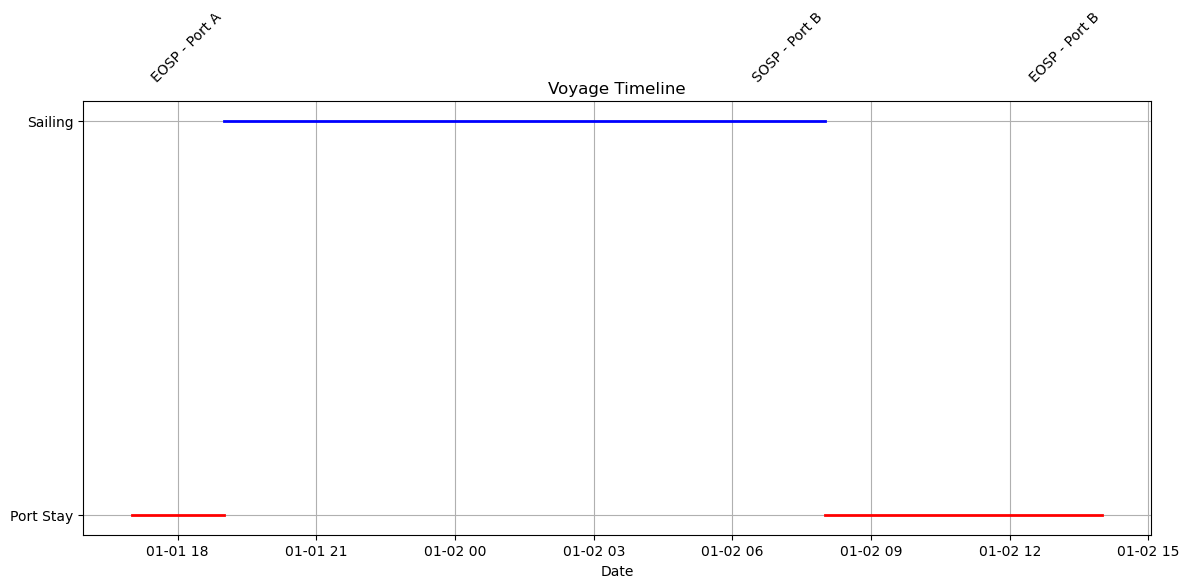

In [42]:
# Visualize the voyage timeline
plt.figure(figsize=(12, 6))
for i in range(1, len(df)):
    start_time = df.iloc[i-1]['event_datetime']
    end_time = df.iloc[i]['event_datetime']
    segment_type = df.iloc[i]['segment_type']
    if segment_type == 'Sailing':
        plt.plot([start_time, end_time], [1, 1], 'b-', linewidth=2)
    elif segment_type == 'Port Stay':
        plt.plot([start_time, end_time], [0, 0], 'r-', linewidth=2)
    plt.text(end_time, 1.1, f"{df.iloc[i]['event']} - {df.iloc[i]['voyage_From']}", rotation=45, ha='right')
plt.yticks([0, 1], ['Port Stay', 'Sailing'])
plt.xlabel('Date')
plt.title('Voyage Timeline')
plt.grid(True)
plt.tight_layout()
plt.show()

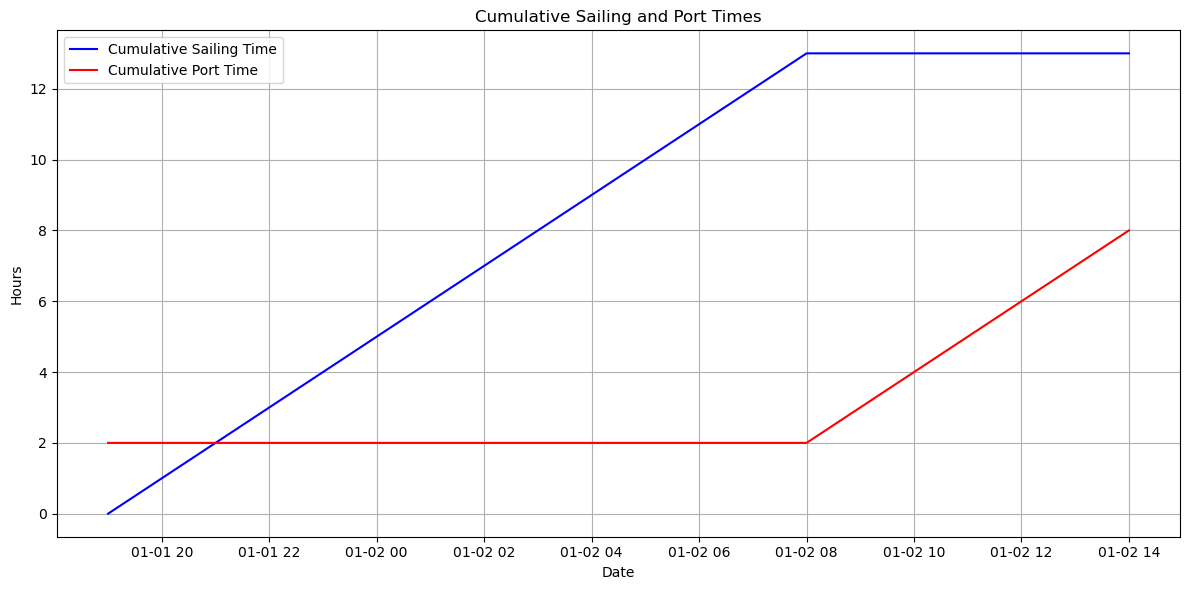

In [43]:
# Plot cumulative times
plt.figure(figsize=(12, 6))
plt.plot(df['event_datetime'], df['cumulative_sailing_time'], 'b-', label='Cumulative Sailing Time')
plt.plot(df['event_datetime'], df['cumulative_port_time'], 'r-', label='Cumulative Port Time')
plt.xlabel('Date')
plt.ylabel('Hours')
plt.title('Cumulative Sailing and Port Times')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

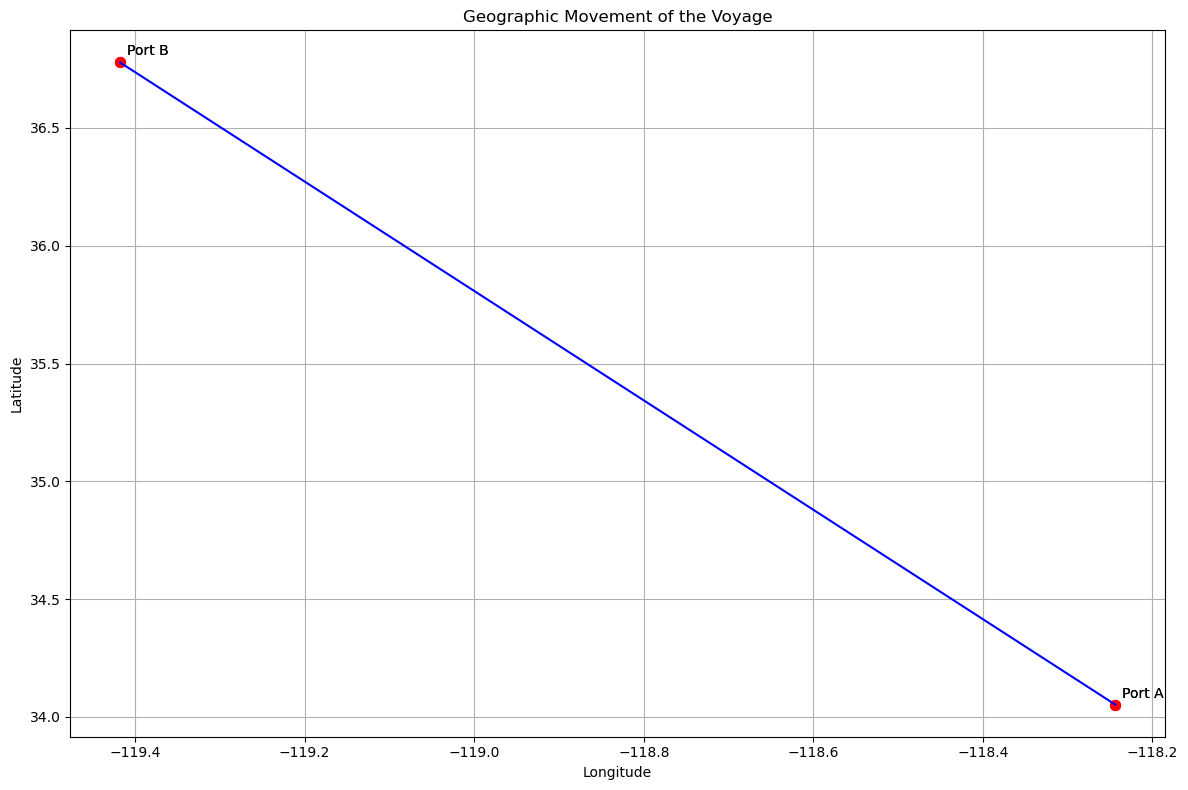

In [44]:
# Plot geographic movement
plt.figure(figsize=(12, 8))
plt.scatter(df['lon'], df['lat'], c='red', s=50)
for i, row in df.iterrows():
    plt.annotate(row['voyage_From'], (row['lon'], row['lat']), xytext=(5, 5), textcoords='offset points')

for i in range(1, len(df)):
    if df.iloc[i]['segment_type'] == 'Sailing':
        plt.plot([df.iloc[i-1]['lon'], df.iloc[i]['lon']], [df.iloc[i-1]['lat'], df.iloc[i]['lat']], 'b-')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Movement of the Voyage')
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
# Display results
print(df[['id', 'event', 'event_datetime', 'voyage_From', 'lat', 'lon', 'segment_type', 'duration', 'distance_travelled', 'cumulative_sailing_time', 'cumulative_port_time']])

   id event             event_datetime voyage_From      lat       lon  \
0   1  SOSP 2020-01-01 16:59:59.971200      Port A  34.0522 -118.2437   
1   2  EOSP 2020-01-01 19:00:00.028800      Port A  34.0522 -118.2437   
2   3  SOSP 2020-01-02 07:59:59.971200      Port B  36.7783 -119.4179   
3   4  EOSP 2020-01-02 13:59:59.971200      Port B  36.7783 -119.4179   

  segment_type   duration  distance_travelled  cumulative_sailing_time  \
0      Unknown        NaN            0.000000                      NaN   
1    Port Stay   2.000016            0.000000                 0.000000   
2      Sailing  12.999984          173.463048                12.999984   
3    Port Stay   6.000000            0.000000                12.999984   

   cumulative_port_time  
0                   NaN  
1              2.000016  
2              2.000016  
3              8.000016  
